In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
import keras
from keras.datasets import fashion_mnist
import torch
from torchvision import datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from scipy.linalg import sqrtm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [3]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [4]:
# calculate frechet inception distance
def calculate_fid(act1, act2):
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0),np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [5]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_data = datasets.FashionMNIST(root='~/.pytorch/FashionMNIST_data/', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='~/.pytorch/FashionMNIST_data/', train=False,
                                  download=True, transform=transform)

100%|██████████| 26421880/26421880 [00:04<00:00, 6430124.97it/s]


Extracting /root/.pytorch/FashionMNIST_data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /root/.pytorch/FashionMNIST_data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 134983.09it/s]


Extracting /root/.pytorch/FashionMNIST_data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /root/.pytorch/FashionMNIST_data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 2508441.22it/s]


Extracting /root/.pytorch/FashionMNIST_data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /root/.pytorch/FashionMNIST_data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17597617.76it/s]

Extracting /root/.pytorch/FashionMNIST_data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /root/.pytorch/FashionMNIST_data/FashionMNIST/raw



In [6]:
num_workers=0
batch_size=32

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

---


(1, 28, 28)     (28, 28)


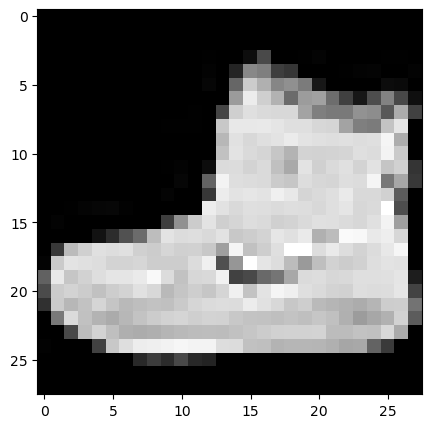

In [7]:
### Visualize data from DataLoader

# obtain one batch of training images
dataiter = iter(train_loader)
images,_= next(dataiter)
images = images.numpy()

# get one image from the batch
img = np.squeeze(images[0]) # (1, 28, 28) -> (28,28)
print(images[0].shape,"   ", np.squeeze(images[0]).shape)

fig = plt.figure(figsize = (5,5)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')

---

In [8]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder,self).__init__()
        ## Encoder Layers ##
        self.conv1 = nn.Conv2d(1,16,3,padding='same')
        self.pool1 = nn.MaxPool2d(2, 2)
        self.batch_norm1 = nn.BatchNorm2d(16)
        
        self.conv2 = nn.Conv2d(16,32,3,padding='same')
        self.batch_norm2 = nn.BatchNorm2d(32)
        
        self.conv3 = nn.Conv2d(32,64,3,padding='same')
        self.pool2 = nn.MaxPool2d(2, 2)
        self.batch_norm3 = nn.BatchNorm2d(64) 
        
        self.conv4 = nn.Conv2d(64,32,3,padding='same')
        self.batch_norm4 = nn.BatchNorm2d(32) 
        
        self.conv5 = nn.Conv2d(32,16,3,padding='same')
        
        ## Decoder Layers ##
        self.t_conv1 = nn.ConvTranspose2d(16,32,2,stride=2)
        self.t_conv2 = nn.ConvTranspose2d(32,64,4,stride=1)
        self.t_conv3 = nn.ConvTranspose2d(64,32,4,stride=1)
        self.t_conv4 = nn.ConvTranspose2d(32,32,5,stride=1)
        self.t_conv5 = nn.ConvTranspose2d(32,16,3,stride=1)
        self.t_conv6 = nn.ConvTranspose2d(16,16,2,stride=1)
        self.t_conv7 = nn.ConvTranspose2d(16,1,2,stride=1)
        
    def forward(self,x):
        ## encode ##
        x = F.elu(self.conv1(x))
        x = self.pool1(x)
        x = self.batch_norm1(x)
        
        x = F.elu(self.conv2(x))
        x = self.batch_norm2(x)
        
        x = F.elu(self.conv3(x))
        x = self.pool2(x)
        x = self.batch_norm3(x)
        
        x = F.elu(self.conv4(x))
        x = self.batch_norm4(x)
        x = F.elu(self.conv5(x))
        
        ## decode ##
        x = F.elu(self.t_conv1(x))
        x = F.elu(self.t_conv2(x))
        x = F.elu(self.t_conv3(x))
        x = F.elu(self.t_conv4(x))
        x = F.elu(self.t_conv5(x))
        x = F.elu(self.t_conv6(x))
        x = F.sigmoid(self.t_conv7(x))
        
        return x
    
model = ConvAutoencoder()
print(model)

ConvAutoencoder(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch_norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (batch_norm4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (t_conv1): ConvTranspose2d(16, 32, kernel_size=

In [9]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [10]:
n_epochs = 15

for epoch in range(1, n_epochs+1):
    train_loss = 0.0
    
    for data in train_loader:
        images,_ = data
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model(images)
        # calculate the loss
        loss = criterion(outputs, images)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*images.size(0)
        
    
    # print avg training statistics 
    train_loss = train_loss/len(train_loader)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(epoch, train_loss))

Epoch: 1 	Training Loss: 0.586381
Epoch: 2 	Training Loss: 0.310973
Epoch: 3 	Training Loss: 0.253557
Epoch: 4 	Training Loss: 0.219432
Epoch: 5 	Training Loss: 0.195259
Epoch: 6 	Training Loss: 0.176429
Epoch: 7 	Training Loss: 0.161436
Epoch: 8 	Training Loss: 0.149650
Epoch: 9 	Training Loss: 0.140251
Epoch: 10 	Training Loss: 0.132578
Epoch: 11 	Training Loss: 0.126189
Epoch: 12 	Training Loss: 0.120775
Epoch: 13 	Training Loss: 0.116069
Epoch: 14 	Training Loss: 0.111958
Epoch: 15 	Training Loss: 0.108290


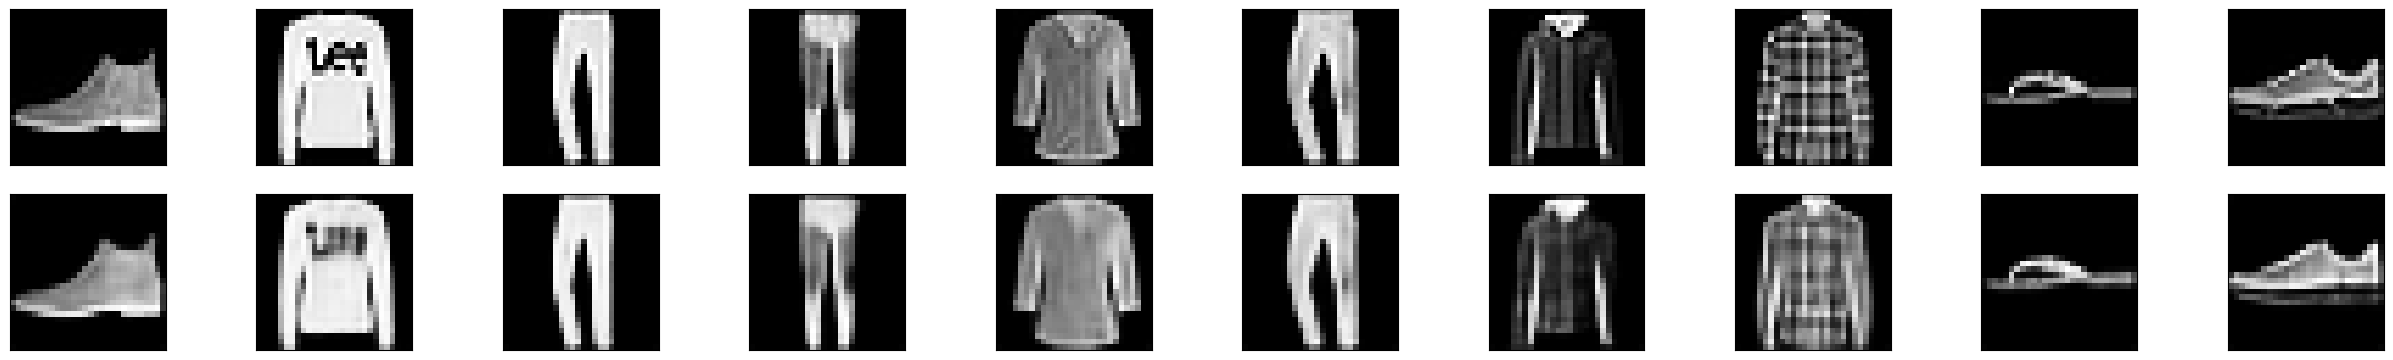

In [11]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

output = model(images)
images = images.numpy()


output = output.view(batch_size, 1, 28, 28)
output = output.detach().numpy()


fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))
plt.tight_layout()

# input images on top row, reconstructions on bottom
for images, row in zip([images, output], axes):
    for img, ax in zip(images, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

In [12]:
fid_agg=0
for i in range(32):
    fid_agg+=calculate_fid(output[i][0],images[i][0])
fid_agg=fid_agg/32

print(f"averate FID score in the first batch:{fid_agg}")                  

averate FID score in the first batch:-1.7123307635919166e-08
